# # ✅ SARIMA(p, d, q, m) 모델을 활용한 테슬라 주가 예측

In [ ]:
!pip install pmdarima yfinance --quiet

In [ ]:
!pip install --upgrade --force-reinstall numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have n

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


🔎 최종 시계열 데이터 확인
Date
2022-01-03    399.926666
2022-01-04    383.196655
2022-01-05    362.706665
2022-01-06    354.899994
2022-01-07    342.320007
Freq: D, Name: Close, dtype: float64 
 Date
2023-12-25    252.539993
2023-12-26    256.609985
2023-12-27    261.440002
2023-12-28    253.179993
2023-12-29    248.479996
Freq: D, Name: Close, dtype: float64
Train Data Range: 2022-01-03 00:00:00 ~ 2023-08-05 00:00:00
Test  Data Range: 2023-08-06 00:00:00 ~ 2023-12-29 00:00:00
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=4047.581, Time=2.69 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4047.494, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4048.134, Time=3.02 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4048.226, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4046.077, Time=0.15 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=4046.812, Time=1.43 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=4046.828, Time=1.81 sec
 ARIMA(0,1,0)(1,0,1)[7]

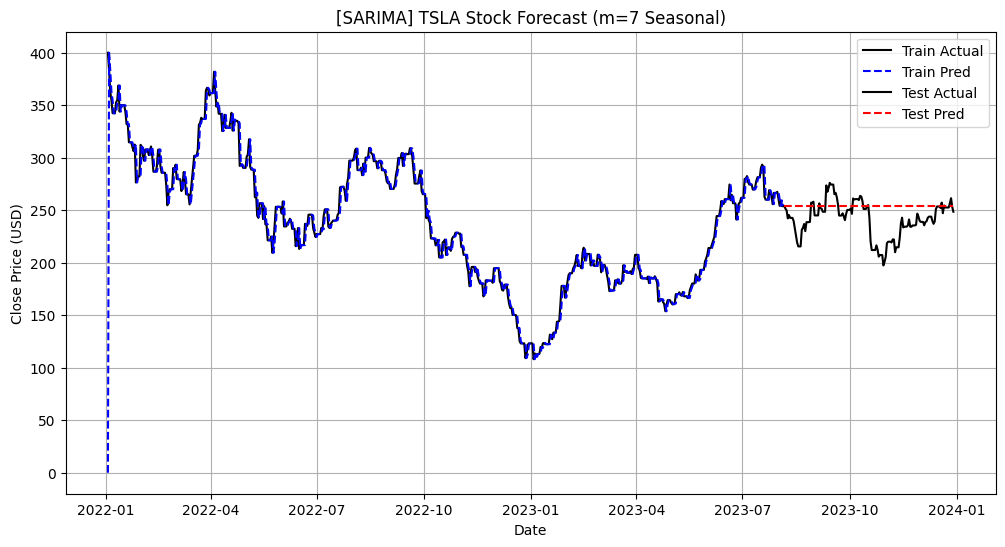

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# SARIMA용 라이브러리
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

# ◆ 1) 데이터 불러오기: 테슬라 주가 (예: 2022-01-01 ~ 2024-01-01)
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")

# multi-index 제거 (yfinance가 multi-column 인덱스로 제공할 수 있음)
df.columns = df.columns.droplevel(1)  # ('Price','Close') 같은 구조 -> 'Close'
df.reset_index(inplace=True)

# 종가(Close) 시계열만 사용
# 날짜(Date)를 시계열 인덱스로 설정 (편의상)
df.set_index("Date", inplace=True)
ts_data = df["Close"].asfreq("D")  # 일 단위(D) 주기로 세팅(결측 자동생성 가능)
ts_data = ts_data.fillna(method="ffill")  # 주말·공휴일 결측을 앞 값으로 대체

print("🔎 최종 시계열 데이터 확인")
print(ts_data.head(), "\n", ts_data.tail())

# ◆ 2) 학습 / 테스트 세트 분할
train_size = int(len(ts_data) * 0.8)
train_data = ts_data.iloc[:train_size]
test_data  = ts_data.iloc[train_size:]

print(f"Train Data Range: {train_data.index[0]} ~ {train_data.index[-1]}")
print(f"Test  Data Range: {test_data.index[0]} ~ {test_data.index[-1]}")

# ◆ 3) 계절성 포착을 위한 m 설정
# 일간 데이터에서 주봉(주간) 수준의 계절성이 있다고 가정하면 m=7
# 필요에 따라 m=5(주중 거래일), m=30(월간 주기) 등으로 조정 가능
m_value = 7

# auto_arima로 (p,d,q)(P,D,Q,m) 자동 탐색
# seasonal=True, m=7
auto_model = auto_arima(
    train_data,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True, m=m_value,  # ← 계절성 on, m=7
    d=None, D=None,
    stepwise=True, trace=True,
    information_criterion='aic'
)

print("\n✅ auto_arima 최적 모델 요약")
print(auto_model.summary())

# (p,d,q)(P,D,Q,m) 추출
order = auto_model.order          # (p,d,q)
seasonal_order = auto_model.seasonal_order  # (P,D,Q,m)
print(f"\n✅ 최적 (p,d,q)  = {order}")
print(f"✅ 최적 (P,D,Q,m) = {seasonal_order}")

# ◆ 4) SARIMA 모델 피팅 (statsmodels의 SARIMAX 사용)
model_sarima = SARIMAX(
    train_data,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = model_sarima.fit(disp=False)
print("\n✅ SARIMA 모델 학습 완료")

# ◆ 5) 예측(포인트 예측) 수행
#  - 학습 구간 내 예측
train_pred = sarima_fit.predict(start=train_data.index[0], end=train_data.index[-1])

#  - 테스트 구간(미래) 예측
test_pred = sarima_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# ◆ 6) 성능 평가
train_mse = mean_squared_error(train_data, train_pred)
test_mse  = mean_squared_error(test_data,  test_pred)
train_r2  = r2_score(train_data, train_pred)
test_r2   = r2_score(test_data,  test_pred)
print(f"\n[Train] MSE: {train_mse:.3f}, R²: {train_r2:.3f}")
print(f"[Test]  MSE: {test_mse:.3f}, R²: {test_r2:.3f}")

# ◆ 7) 시각화: 전체 시계열 + 예측 결과
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label="Train Actual", color="black")
plt.plot(train_pred.index, train_pred, label="Train Pred", linestyle="--", color="blue")

plt.plot(test_data.index, test_data, label="Test Actual", color="black")
plt.plot(test_pred.index, test_pred, label="Test Pred", linestyle="--", color="red")

plt.title(f"[SARIMA] TSLA Stock Forecast (m={m_value} Seasonal)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


롤링기법 추가 & m = 3개월

[*********************100%***********************]  1 of 1 completed


🔎 최종 시계열 데이터 확인
Date
2022-01-03    399.926666
2022-01-04    383.196655
2022-01-05    362.706665
2022-01-06    354.899994
2022-01-07    342.320007
Freq: D, Name: Close, dtype: float64 
 Date
2023-12-25    252.539993
2023-12-26    256.609985
2023-12-27    261.440002
2023-12-28    253.179993
2023-12-29    248.479996
Freq: D, Name: Close, dtype: float64
Train Data Range: 2022-01-03 00:00:00 ~ 2023-08-05 00:00:00
Test  Data Range: 2023-08-06 00:00:00 ~ 2023-12-29 00:00:00
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[90] intercept   : AIC=4047.581, Time=3.10 sec
 ARIMA(0,1,0)(0,0,0)[90] intercept   : AIC=4047.494, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[90] intercept   : AIC=4049.485, Time=21.40 sec
 ARIMA(0,1,1)(0,0,1)[90] intercept   : AIC=4049.598, Time=26.30 sec
 ARIMA(0,1,0)(0,0,0)[90]             : AIC=4046.077, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[90] intercept   : AIC=4048.293, Time=12.97 sec
 ARIMA(0,1,0)(0,0,1)[90] intercept   : AIC=4048.361, Time=10.72 sec
 ARIMA(0,1,0

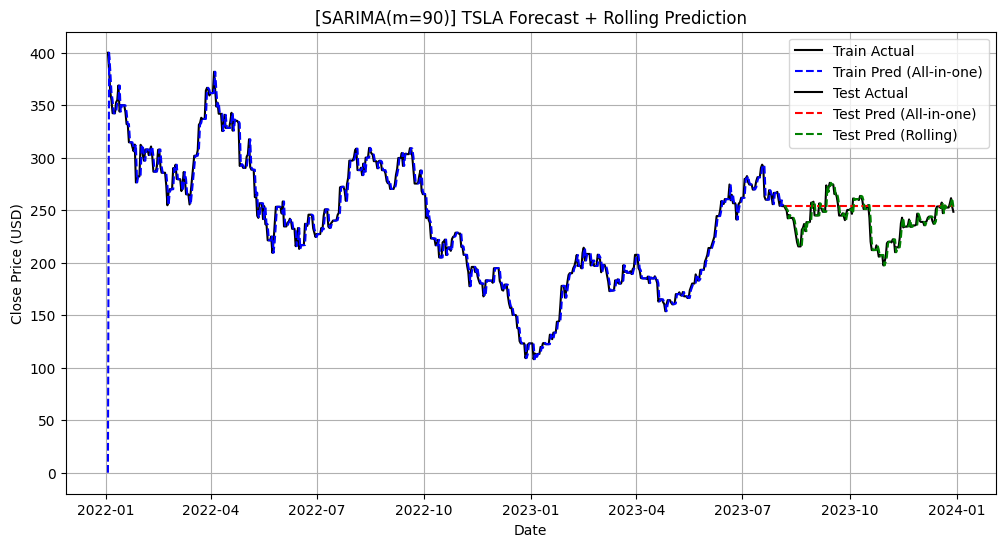

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

# 1) 데이터 불러오기
df = yf.download("TSLA", start="2022-01-01", end="2024-01-01")

# yfinance가 MultiIndex로 반환할 수 있음 -> droplevel(1)
df.columns = df.columns.droplevel(1)
df.reset_index(inplace=True)

# 종가만 사용, 날짜를 인덱스로 세팅
df.set_index("Date", inplace=True)

# 일 단위로 재샘플링 (D), 결측은 앞의 값으로 채움
ts_data = df["Close"].asfreq("D")
ts_data = ts_data.fillna(method="ffill")

print("🔎 최종 시계열 데이터 확인")
print(ts_data.head(), "\n", ts_data.tail())

# 2) 학습/테스트 구간 분할
train_size = int(len(ts_data) * 0.8)
train_data = ts_data.iloc[:train_size]
test_data = ts_data.iloc[train_size:]

print(f"Train Data Range: {train_data.index[0]} ~ {train_data.index[-1]}")
print(f"Test  Data Range: {test_data.index[0]} ~ {test_data.index[-1]}")

# 3) auto_arima로 (p,d,q)(P,D,Q,m) 자동 탐색
# 여기서 m=90으로 설정 (약 3개월 = 분기)
m_value = 90

auto_model = auto_arima(
    train_data,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    seasonal=True, m=m_value,     # 분기단위 계절성을 가정
    d=None, D=None,
    stepwise=True, trace=True,
    information_criterion='aic'
)

print("\n✅ auto_arima 최적 모델 요약")
print(auto_model.summary())

order = auto_model.order
seasonal_order = auto_model.seasonal_order
print(f"\n✅ 최적 (p,d,q)  = {order}")
print(f"✅ 최적 (P,D,Q,m) = {seasonal_order}")

# 4) 학습데이터로 SARIMA 모델 피팅
model_sarima = SARIMAX(
    train_data,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = model_sarima.fit(disp=False)
print("\n✅ SARIMA 모델 학습 완료")

# 5) 학습구간 내부 예측 / 테스트구간 예측 (전체 예측)
train_pred = sarima_fit.predict(start=train_data.index[0], end=train_data.index[-1])
test_pred  = sarima_fit.predict(start=test_data.index[0],  end=test_data.index[-1])

# 6) 성능평가 (일괄 예측)
train_mse = mean_squared_error(train_data, train_pred)
test_mse  = mean_squared_error(test_data,  test_pred)
train_r2  = r2_score(train_data, train_pred)
test_r2   = r2_score(test_data,  test_pred)
print(f"\n[Train] MSE: {train_mse:.3f}, R²: {train_r2:.3f}")
print(f"[Test]  MSE: {test_mse:.3f}, R²: {test_r2:.3f}")

# --------------------------------------
# 7) 롤링 예측(One-step rolling forecast) 추가
#    테스트 구간의 각 날짜를 한 스텝씩 순차적으로 예측하고, 그 관측값을 history에 업데이트
# --------------------------------------

print("\n🔄 롤링 예측(One-step forecasting) 진행 중...")

rolling_preds = []
history = train_data.copy()  # 훈련 데이터 전체를 초기 history로 설정

for date in test_data.index:
    # 7-1) 현재 history를 기반으로 SARIMA 모델 재적합
    #      (주로 p,d,q,P,D,Q,m은 고정, 데이터만 업데이트)
    model_rolling = SARIMAX(
        history,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fit_rolling = model_rolling.fit(disp=False)

    # 7-2) 다음 시점(= date)에 대한 예측 (1 스텝)
    pred = fit_rolling.predict(start=date, end=date)
    rolling_preds.append(pred.iloc[0])

    # 7-3) 실제 관측값을 history에 추가
    actual_val = test_data.loc[date]
    history.loc[date] = actual_val

# rolling_preds를 시계열로 만들기
rolling_preds_series = pd.Series(rolling_preds, index=test_data.index)

# 8) 롤링 예측 성능평가
rolling_mse = mean_squared_error(test_data, rolling_preds_series)
rolling_r2  = r2_score(test_data, rolling_preds_series)
print(f"\n✅ Rolling Forecast MSE: {rolling_mse:.3f}")
print(f"✅ Rolling Forecast R² : {rolling_r2:.3f}")

# --------------------------------------
# 9) 시각화 (학습/테스트 + 예측)
# --------------------------------------

plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label="Train Actual", color="black")
plt.plot(train_pred.index, train_pred, label="Train Pred (All-in-one)",
         linestyle="--", color="blue")

plt.plot(test_data.index, test_data, label="Test Actual", color="black")
plt.plot(test_pred.index, test_pred, label="Test Pred (All-in-one)",
         linestyle="--", color="red")

plt.plot(rolling_preds_series.index, rolling_preds_series,
         label="Test Pred (Rolling)", linestyle="--", color="green")

plt.title(f"[SARIMA(m={m_value})] TSLA Forecast + Rolling Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


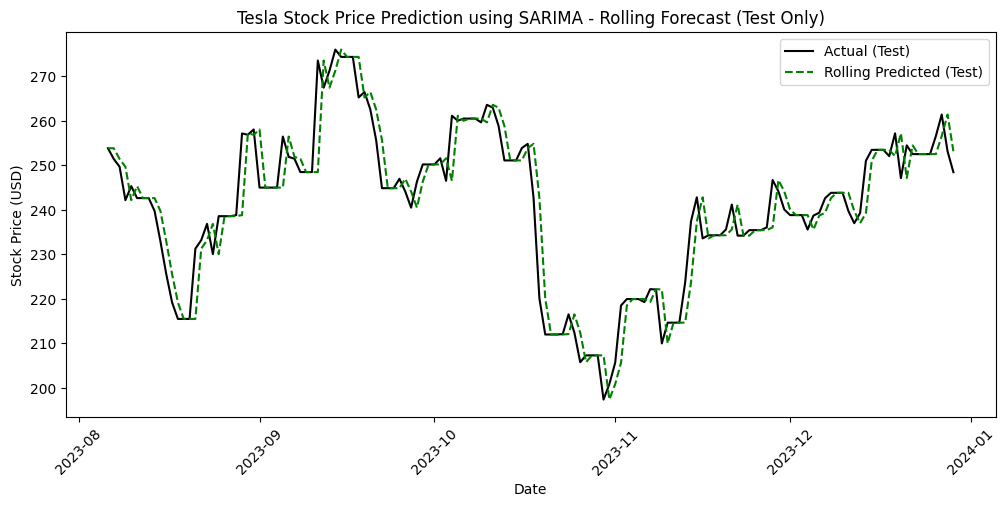

In [ ]:
# 10) 📌 (추가) 테스트 데이터 구간만 별도로 시각화 (롤링 예측 vs 실제값)
plt.figure(figsize=(12, 5))
plt.plot(test_data.index, test_data.values, label="Actual (Test)", color="black")
plt.plot(rolling_preds_series.index, rolling_preds_series.values,
         label="Rolling Predicted (Test)", linestyle="--", color="green")
plt.title("Tesla Stock Price Prediction using SARIMA - Rolling Forecast (Test Only)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


TSLA: 501 obs | 2022-01-03 ~ 2023-12-29
train=400, test=101
[Full] best order=(2, 0, 1), seasonal=(1, 0, 1, 5), AIC=12.00


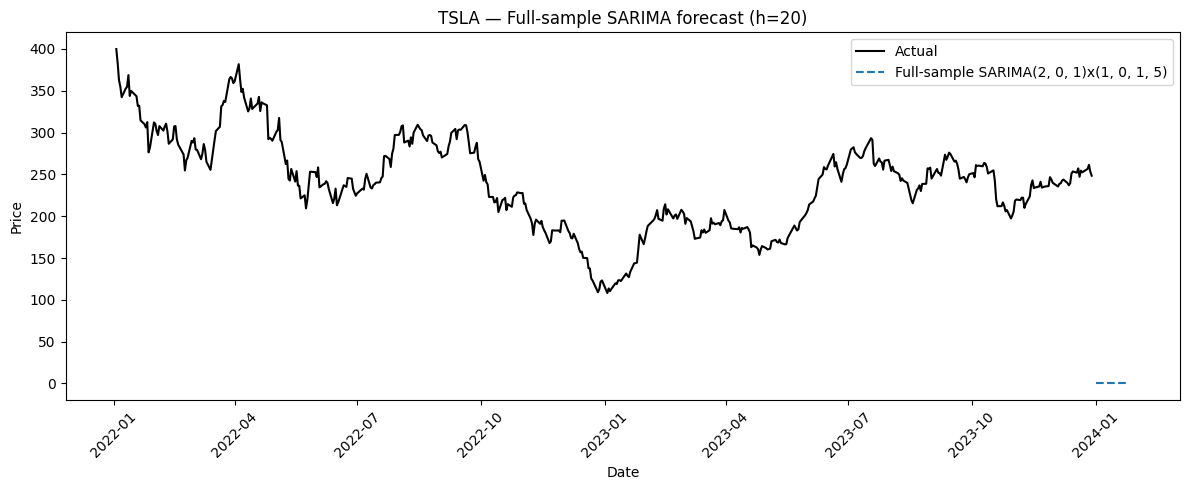

[Fixed-origin] best order=(2, 1, 2), seasonal=(0, 0, 0, 5), AIC=2922.19
[Fixed-origin] RMSE=20.3602 | MAE=15.5507 | R2=-0.3654


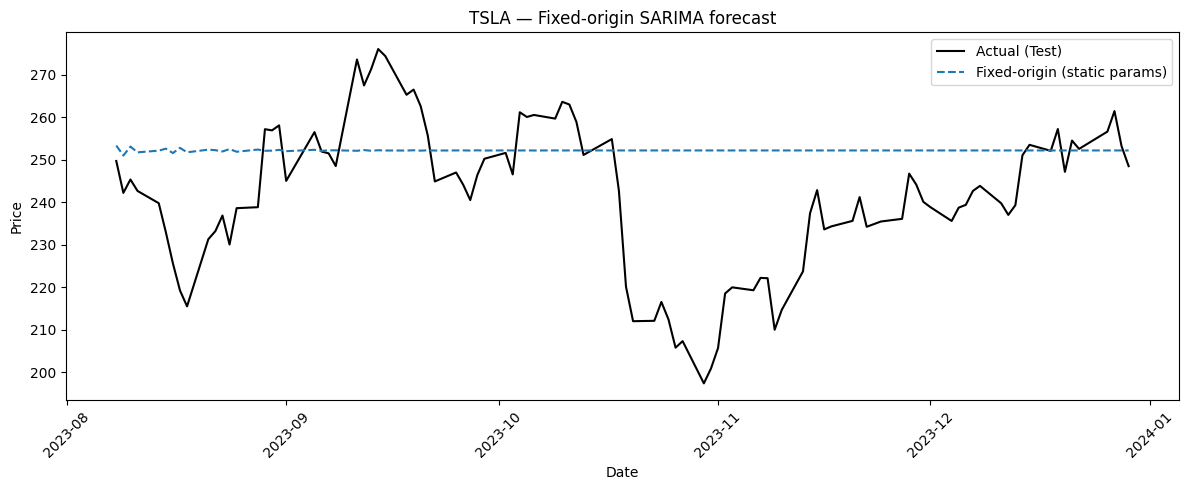

[Rolling window] RMSE=42.1982 | MAE=26.5777 | R2=-4.8651


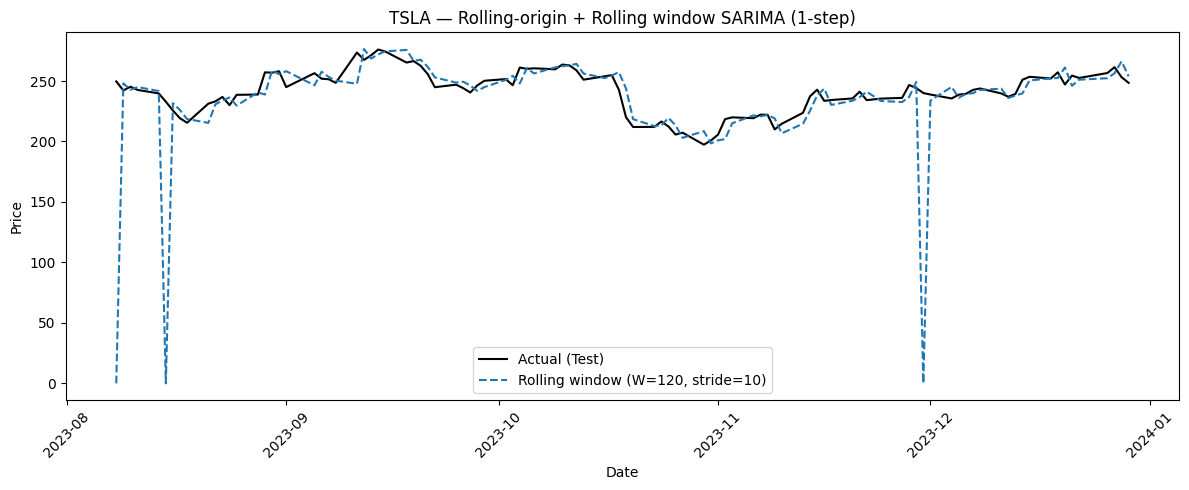

[Expanding window] RMSE=382959.8871 | MAE=38125.5221 | R2=-483051486.5091


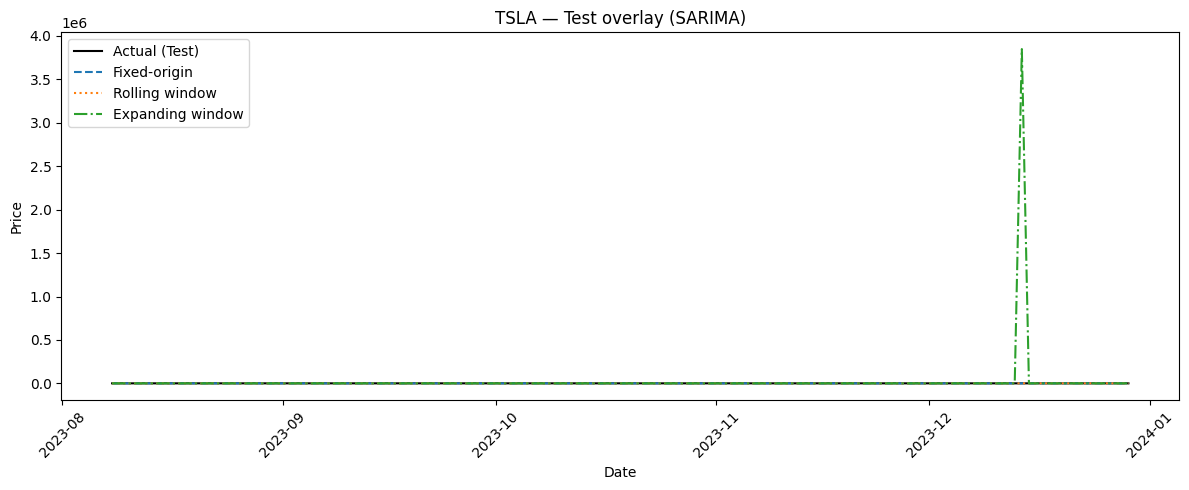


=== Summary (Test) ===


,Method,RMSE,MAE,R2
0,Fixed-origin,20.360173,15.550704,-3.653681e-01
1,"Rolling (W=120, stride=10)",42.198237,26.577734,-4.865101e+00
2,Expanding (stride=10),382959.887095,38125.522107,-4.830515e+08


In [3]:
# =========================================================
# Colab 준비 (필요시만 실행)
# =========================================================
# %pip -q install yfinance statsmodels scikit-learn

import warnings
from itertools import product

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
try:
    # 일부 경고 타입은 버전에 따라 경로가 다를 수 있음
    from statsmodels.tsa.base.tsa_model import ValueWarning
except Exception:
    class ValueWarning(Warning):  # 미존재시 더미
        pass

# ---- 경고 억제 ----
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams["figure.figsize"] = (12, 5)

# =========================================================
# 1) 데이터 로드
# =========================================================
symbol     = "TSLA"
start_date = "2022-01-01"
end_date   = "2024-01-01"

px = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True).reset_index()

px = px[["Date", "Close"]].dropna().copy()
px["Date"] = pd.to_datetime(px["Date"])

y = px["Close"].to_numpy(dtype=float)
dates = px["Date"]                       # ← Series로 유지(NumPy로 변환 X)

print(f"{symbol}: {len(y)} obs | {dates.iloc[0].date()} ~ {dates.iloc[-1].date()}")
# =========================================================
# 2) 학습/테스트 분할
# =========================================================
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
dates_train, dates_test = dates[:train_size], dates[train_size:]
print(f"train={len(y_train)}, test={len(y_test)}")

# =========================================================
# 3) 유틸 함수
# =========================================================
def rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))
def mae(a, b):  return float(np.mean(np.abs(a - b)))
def r2(a, b):   return float(r2_score(a, b))

def fit_sarima_safe(y_arr, order, seasonal_order, maxiter=200):
    """
    SARIMA 안전 적합: 실패 시 다른 optimizer로 재시도 → 그래도 실패하면 None 반환.
    """
    def _try(method):
        try:
            model = SARIMAX(
                y_arr, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=True, enforce_invertibility=True
            )
            return model.fit(method=method, maxiter=maxiter, disp=False)
        except Exception:
            return None

    for method in ("lbfgs", "powell", "nm"):  # 순차 재시도
        fit = _try(method)
        if fit is not None:
            return fit
    return None

def auto_sarima_aic(y_arr, p_range=(0,1,2), d_range=(0,1), q_range=(0,1,2),
                    P_range=(0,1), D_range=(0,1), Q_range=(0,1), S=5,
                    maxiter=200):
    """
    작은 그리드에서 AIC 최소가 되는 (p,d,q)(P,D,Q,S) 선택.
    """
    best = {"aic": np.inf, "order": None, "seasonal_order": None, "fit": None}
    for p, d, q in product(p_range, d_range, q_range):
        for P, D, Q in product(P_range, D_range, Q_range):
            order = (p, d, q)
            seas  = (P, D, Q, S)
            fit = fit_sarima_safe(y_arr, order, seas, maxiter=maxiter)
            if fit is None or not np.isfinite(getattr(fit, "aic", np.inf)):
                continue
            if fit.aic < best["aic"]:
                best = {"aic": fit.aic, "order": order, "seasonal_order": seas, "fit": fit}
    # 실패 시 fallback
    if best["fit"] is None:
        order = (1, 1, 1)
        seas  = (0, 1, 0, S)
        fit = fit_sarima_safe(y_arr, order, seas, maxiter=maxiter)
        best = {"aic": getattr(fit, "aic", np.inf), "order": order, "seasonal_order": seas, "fit": fit}
    return best

def one_step_forecast(y_hist, order, seasonal_order):
    """
    1-step ahead 예측값 반환. 실패 시 naive(마지막 관측값) 사용.
    """
    fit = fit_sarima_safe(y_hist, order, seasonal_order, maxiter=200)
    if fit is None:
        return float(y_hist[-1])  # naive
    try:
        return float(fit.forecast(1)[0])
    except Exception:
        return float(y_hist[-1])

# =========================================================
# 4) 하이퍼(계절 주기, 창 길이 등)
# =========================================================
S = 5          # 계절주기: 거래일 기준 주간 패턴 ≈ 5
W = 120        # Rolling 창 길이
stride = 10    # 롤링/확장에서 매 stride마다 모형 재선택 (0이면 고정)
GRID = dict(   # AIC 그리드 (무리 없도록 작게)
    p_range=(0,1,2),
    d_range=(0,1),
    q_range=(0,1,2),
    P_range=(0,1),
    D_range=(0,1),
    Q_range=(0,1)
)

# =========================================================
# 5) A) Full-sample (final fit)
#    - 전체 표본으로 모형 선택/적합 → 미래 h 스텝 예측 (평가용 X)
# =========================================================
h = 20  # 예: 20 영업일
full_sel = auto_sarima_aic(y, S=S, **GRID)
full_fit = full_sel["fit"]
print(f"[Full] best order={full_sel['order']}, seasonal={full_sel['seasonal_order']}, AIC={full_sel['aic']:.2f}")

future_fcst = (full_fit.forecast(h).astype(float)
               if full_fit is not None else np.full(h, y[-1], dtype=float))
future_dates = pd.bdate_range(pd.Timestamp(dates.iloc[-1]) + pd.Timedelta(days=1), periods=h)

plt.figure()
plt.plot(dates, y, label="Actual", color="black")
plt.plot(future_dates, future_fcst, label=f"Full-sample SARIMA{full_sel['order']}x{full_sel['seasonal_order']}", linestyle="--")
plt.title(f"{symbol} — Full-sample SARIMA forecast (h={h})")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# 6) B) Fixed-origin (single-origin / holdout)
#    - 학습(80%)에 대해 모형 선택/적합 → 테스트 전구간 한 번에 예측
# =========================================================
fix_sel = auto_sarima_aic(y_train, S=S, **GRID)
fix_fit = fix_sel["fit"]
print(f"[Fixed-origin] best order={fix_sel['order']}, seasonal={fix_sel['seasonal_order']}, AIC={fix_sel['aic']:.2f}")

pred_fix = (fix_fit.forecast(len(y_test)).astype(float)
            if fix_fit is not None else np.full(len(y_test), y_train[-1], dtype=float))

rmse_fix, mae_fix, r2_fix = rmse(y_test, pred_fix), mae(y_test, pred_fix), r2(y_test, pred_fix)
print(f"[Fixed-origin] RMSE={rmse_fix:.4f} | MAE={mae_fix:.4f} | R2={r2_fix:.4f}")

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black")
plt.plot(dates_test, pred_fix, label="Fixed-origin (static params)", linestyle="--")
plt.title(f"{symbol} — Fixed-origin SARIMA forecast")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# 7) C) Rolling-origin + Rolling window
#    - 창 길이 W로 최근 데이터만 사용해 매 스텝 1-step 재적합/예측
#    - (옵션) stride마다 모형 재선택 (AIC)
# =========================================================
pred_roll = np.full(len(y_test), np.nan, dtype=float)
hist = y_train.copy()
current_order, current_seasonal = fix_sel["order"], fix_sel["seasonal_order"]  # 초기값: 학습 구간 선택

for i in range(len(y_test)):
    y_win = hist[-W:] if len(hist) >= W else hist
    if stride and (i % stride == 0):
        sel = auto_sarima_aic(y_win, S=S, **GRID)
        current_order, current_seasonal = sel["order"], sel["seasonal_order"]
    pred_roll[i] = one_step_forecast(y_win, current_order, current_seasonal)
    # 워크-포워드 (실제값 주입)
    hist = np.append(hist, y_test[i])

rmse_r, mae_r, r2_r = rmse(y_test, pred_roll), mae(y_test, pred_roll), r2(y_test, pred_roll)
print(f"[Rolling window] RMSE={rmse_r:.4f} | MAE={mae_r:.4f} | R2={r2_r:.4f}")

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black")
plt.plot(dates_test, pred_roll, label=f"Rolling window (W={W}, stride={stride})", linestyle="--")
plt.title(f"{symbol} — Rolling-origin + Rolling window SARIMA (1-step)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# 8) D) Rolling-origin + Expanding window (recursive)
#    - 누적 창으로 매 스텝 1-step 재적합/예측
#    - (옵션) stride마다 모형 재선택 (AIC)
# =========================================================
pred_exp = np.full(len(y_test), np.nan, dtype=float)
hist = y_train.copy()
current_order, current_seasonal = fix_sel["order"], fix_sel["seasonal_order"]

for i in range(len(y_test)):
    if stride and (i % stride == 0):
        sel = auto_sarima_aic(hist, S=S, **GRID)
        current_order, current_seasonal = sel["order"], sel["seasonal_order"]
    pred_exp[i] = one_step_forecast(hist, current_order, current_seasonal)
    hist = np.append(hist, y_test[i])

rmse_e, mae_e, r2_e = rmse(y_test, pred_exp), mae(y_test, pred_exp), r2(y_test, pred_exp)
print(f"[Expanding window] RMSE={rmse_e:.4f} | MAE={mae_e:.4f} | R2={r2_e:.4f}")

plt.figure()
plt.plot(dates_test, y_test, label="Actual (Test)", color="black", linewidth=1.5)
plt.plot(dates_test, pred_fix,  label="Fixed-origin", linestyle="--")
plt.plot(dates_test, pred_roll, label="Rolling window", linestyle=":")
plt.plot(dates_test, pred_exp,  label="Expanding window", linestyle="-.")
plt.title(f"{symbol} — Test overlay (SARIMA)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# 9) 요약 표
# =========================================================
summary = pd.DataFrame({
    "Method": ["Fixed-origin", f"Rolling (W={W}, stride={stride})", f"Expanding (stride={stride})"],
    "RMSE":   [rmse_fix, rmse_r, rmse_e],
    "MAE":    [mae_fix,  mae_r,  mae_e],
    "R2":     [r2_fix,   r2_r,   r2_e],
})
print("\n=== Summary (Test) ===")
display(summary.sort_values("RMSE"))